### This file contains the same code as xlm-roberta-span-token.ipynb, but does classification on [SPAN_START] token instead of default [CLS] 
#### This approach showed the best results so far in the test accuracy and faster convergence of the test-loss.
##### Confusion matrix is included in the end, with added commentary.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# sub1 = 'drive/My Drive/Colab Notebooks/semeval_data/subtask1.parquet'
# print(sub1)

from pathlib import Path
wd = Path.cwd()
wd = wd.parent.parent
wd = wd / 'merged_data'
sub1 = str(wd) + '/subtask1.parquet'
print(sub1)

/home/matijak/Documents/programiranje/projects/semeval/merged_data/subtask1.parquet


In [2]:
import pandas as pd
df = pd.read_parquet(sub1)

In [3]:
import re
def labelNum(row):
    if row['class1'] == 'Antagonist':
        return int(0)
    if row['class1'] == 'Innocent':
        return int(1)
    if row['class1'] == 'Protagonist':
        return int(2)
def cleanText(row):
    text = str(row['text'])
    #text = re.sub(r'[^\w\s]', ' ', text)
    text = text.replace('\n',' ').replace('  ', ' ')
    return text
df['label'] = df.apply(labelNum,axis=1)
df['input'] = df.apply(cleanText,axis=1)

In [4]:
def find_all_substring_start_end(text, substring):
    # Use re.finditer to find all occurrences of the substring in the text
    matches = re.finditer(re.escape(substring), text)

    # Collect the start and end indices of all matches
    positions = [(match.start(), match.end()) for match in matches]

    return positions
def adjust_start_end(row):
    org_text,cl_text,start,end,entity = str(row['text']),str(row['input']),int(row['start']),int(row['end']),str(row['entity'])
    ss1 = find_all_substring_start_end(org_text,entity)
    ss2 = find_all_substring_start_end(cl_text,entity)
    #print(ss1,ss2)
    #print(row['text'][start:end])
    a = 0
    for i in range(len(ss1)):
        if abs((ss1[i][0] - start) + (ss1[i][1] - end) ) <= 2:
            a = i
            break
    if org_text[ss1[a][0]:ss1[a][1]] != cl_text[ss2[a][0]:ss2[a][1]]:
        print("ERROR!")
    return ss2[a][0],ss2[a][1]
df['new_start_end'] = df.apply(adjust_start_end,axis=1)
print(df.loc[0])

lang                                                            BG
art_name                                                BG_670.txt
entity                                                       Запад
start                                                          152
end                                                            156
class1                                                  Antagonist
classes2              [Conspirator, Instigator, Foreign Adversary]
text             Опитът на колективния Запад да „обезкърви Руси...
label                                                            0
input            Опитът на колективния Запад да „обезкърви Руси...
new_start_end                                           (151, 156)
Name: 0, dtype: object


In [5]:
def addTokensToInput(row):
    inp = row['input']
    start,end = row['new_start_end']
    #print(start,end)
    start = int(start)
    end = int(end)
    token_input = inp[:start] + "[SPAN_START] " + inp[start:end] + " [SPAN_END]" + inp[end:]
    return token_input

df['span_input'] = df.apply(addTokensToInput,axis=1)

In [6]:
def upStartEnd(row):
    start,end = row['new_start_end']
    start += len("[SPAN_START] ")
    end += len("[SPAN_START] ")
    return start,end

df['new_start_end'] = df.apply(upStartEnd,axis = 1)

In [7]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3).to(device)
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

def preprocess_function(examples):
    return tokenizer(examples['span_input'], padding=True, truncation=True,max_length=8192,return_offsets_mapping=True)

Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
extraTokens = {
    "additional_special_tokens": ["[SPAN_START]", "[SPAN_END]"]
}
num_added_toks = tokenizer.add_special_tokens(extraTokens)
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(250004, 768, padding_idx=1)

In [9]:
data = df.loc[ : , ['span_input','label','new_start_end','entity']]
data['tokenized']=data.apply(preprocess_function,axis=1)

In [10]:
def indexes(row):
    off_mask = row['tokenized']['offset_mapping']
    start,end = row['new_start_end'][0],row['new_start_end'][1]
    inds = list()
    for p in range(len(off_mask)):
        if off_mask[p][0] >= start and off_mask[p][1] <= end:
            if p != len(off_mask)-1:
                inds.append(p)
    #if len(inds) > 1:
        #print("GREATER THAN 1")
    if len(inds) == 0:
        print(start,end)
    return inds
data['indexes'] = data.apply(indexes,axis=1)

In [11]:
data['list'] = data['tokenized'].apply(lambda x: x['input_ids'])
data['attention'] = data['tokenized'].apply(lambda x: x['attention_mask'])
ids = data['list']
att = data['attention']
indexes = data['indexes']
tids = list()
tatt = list()
print(len(ids),len(att),len(indexes))
for i in range(len(ids)):
    tids.append(torch.tensor(ids[i]))
    tatt.append(torch.tensor(att[i]))

2902 2902 2902


In [12]:
sliced_ids = list()
sliced_ntids = list()
sliced_att = list()
key_inds = list()
key_ids = list()

def slices(index,size,context_size):
    if (size<context_size):
        return 0,size
    lower_c = int(context_size/2-1)
    upper_c = int(context_size/2)
    #print(lower_c,upper_c)
    if index < lower_c:
        return 0,context_size
    elif index >= lower_c:
        if index + upper_c > size:
            return index-(context_size-(size-index)), size
        else:
            return index-lower_c,index+upper_c+1


for i in range(len(tids)):
    slower,supper = slices(indexes[i][0],len(tids[i]),510)
    #key_tid = tids[i][indexes[i][0]]
    pid = ids[i][slower:supper]
    key_inds.append([])
    for j in indexes[i]:
        key_id = ids[i][j]
        if key_id not in pid:
           print(len(ids[i]),key_id,slower,supper,indexes[i])
        key_inds[i].append(pid.index(key_id))
    apid = tids[i][slower:supper]
    apatt = tatt[i][slower:supper]
    if 0 not in pid:
        apid = torch.cat((torch.tensor([0]),apid),dim=0)
        apatt = torch.cat((torch.tensor([1]),apatt),dim=0)
    if 2 not in pid:
        apid = torch.cat((apid,torch.tensor([2])),dim=0)
        apatt = torch.cat((apatt,torch.tensor([1])),dim=0)
    sliced_ids.append(apid)
    sliced_att.append(apatt)

Min = 10000
Max = 0
ind2 = 0
for i in range(len(indexes)):
    if len(sliced_ids[i]) < Min:
        Min = len(sliced_ids[i])
        ind2 = i

    if len(sliced_ids[i]) > Max:
        Max = len(sliced_ids[i])

In [13]:
input_ids = list()
att_mask = list()
for ten,att in zip(sliced_ids,sliced_att):
    if len(ten) < 512:
        padding_length = 512 - len(ten)
        padding_tensor = torch.full((padding_length,), tokenizer.pad_token_id, dtype=ten.dtype)
        padding_tensor2 = torch.full((padding_length,), 0, dtype=att.dtype)
        ten = torch.cat((ten,padding_tensor),dim=0)
        att = torch.cat((att,padding_tensor2),dim=0)
    input_ids.append(ten)
    att_mask.append(att)
inputIds = torch.stack(input_ids)
attMask = torch.stack(att_mask)

inputIds_np = inputIds.numpy()
attMask_np = attMask.numpy()
y = data['label'].values

In [14]:
from sklearn.model_selection import train_test_split
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    inputIds_np, attMask_np, y, test_size=0.2, random_state=42,
)

In [15]:
X_train_ids = torch.tensor(X_train_ids, dtype=torch.long).to(device)
X_test_ids = torch.tensor(X_test_ids, dtype=torch.long).to(device)
X_train_mask = torch.tensor(X_train_mask, dtype=torch.long).to(device)
X_test_mask = torch.tensor(X_test_mask, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [16]:
# Create TensorDatasets
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn as nn

classifier = nn.Linear(model.config.hidden_size, 3).to(device)
optimizer = AdamW(list(classifier.parameters()) + list(model.parameters()), lr=8e-6)
criterion = nn.CrossEntropyLoss()

In [18]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25, num_classes=3):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = num_classes
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()

#criterion = FocalLoss(gamma=2., alpha=0.25)

In [19]:
import numpy as np
# for the confusion matrix in the end
all_preds = np.array([], dtype=np.int8)
all_labels = np.array([], dtype=np.int8)

In [20]:
num_epochs = 6
debug = 0
for epoch in range(num_epochs):

    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    train_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")

    
    
    for batch in train_progress_bar:
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        batch_size = input_ids.size(0)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_hidden_states=True)

        hidden_states = outputs.hidden_states[-1]

        span_start_token_id = tokenizer.convert_tokens_to_ids('[SPAN_START]')
        span_end_token_id = tokenizer.convert_tokens_to_ids('[SPAN_END]')

        start_mask = (input_ids == span_start_token_id)
        end_mask = (input_ids == span_end_token_id)

        entity_representations = []

        start_indices = start_mask.nonzero(as_tuple=True)[1]
        end_indices = end_mask.nonzero(as_tuple=True)[1]

        # check that span is valid and has non-zero length
        valid_spans = (start_indices != -1) & (end_indices != -1) & (start_indices <= end_indices)

        valid_start_indices = start_indices[valid_spans]
        valid_end_indices = end_indices[valid_spans]

        
        
        # extract entity tokens for every sample in batch
        for i in range(batch_size):
            entity_tokens = hidden_states[i, valid_start_indices[i]]
            entity_representations.append(entity_tokens)
        
        #if epoch == 0:
        #    print(entity_representations)
        
        entity_representations = torch.stack(entity_representations, dim=0)
        if debug == 0:
            print(hidden_states.shape)
            print(start_mask,end_mask)
            print(start_indices,end_indices)
            print(valid_spans)
            print(valid_start_indices,valid_end_indices)
            print(entity_representations.shape)
            debug+=1
        logits = classifier(entity_representations)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(logits, dim=-1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        train_progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training loss: {avg_train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")

    model.eval()
    test_loss = 0
    correct_test_predictions = 0
    total_test_predictions = 0

    test_progress_bar = tqdm(test_dataloader, desc=f"Test Epoch {epoch + 1}/{num_epochs}")

    with torch.no_grad():
        for batch in test_progress_bar:

            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            batch_size = input_ids.size(0)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_hidden_states=True)

            hidden_states = outputs.hidden_states[-1]

            span_start_token_id = tokenizer.convert_tokens_to_ids('[SPAN_START]')
            span_end_token_id = tokenizer.convert_tokens_to_ids('[SPAN_END]')

            start_mask = (input_ids == span_start_token_id)
            end_mask = (input_ids == span_end_token_id)

            entity_representations = []

            start_indices = start_mask.nonzero(as_tuple=True)[1]
            end_indices = end_mask.nonzero(as_tuple=True)[1]

            valid_spans = (start_indices != -1) & (end_indices != -1) & (start_indices <= end_indices)

            valid_start_indices = start_indices[valid_spans]
            valid_end_indices = end_indices[valid_spans]

            # extract entity tokens for every sample in batch
            for i in range(batch_size):
                entity_tokens = hidden_states[i, valid_start_indices[i]]
                entity_representations.append(entity_tokens)

            entity_representations = torch.stack(entity_representations, dim=0)

            logits = classifier(entity_representations)
            loss = criterion(logits, labels)
            test_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            if epoch == num_epochs-1:
                all_preds = np.concatenate((all_preds, preds.cpu().numpy()))
                all_labels = np.concatenate((all_labels, labels.cpu().numpy()))

            correct_test_predictions += (preds == labels).sum().item()
            total_test_predictions += labels.size(0)

            test_progress_bar.set_postfix({'loss': loss.item()})

    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = correct_test_predictions / total_test_predictions

    print(f"Test loss: {avg_test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Training Epoch 1/6:   0%|                                                                                                                            | 0/146 [00:00<?, ?it/s]

torch.Size([16, 512, 768])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0') tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')
tensor([133, 139,  12, 487,  31, 291,  88, 129,  66, 254,  13, 167, 385,  22,
        254,  45], device='cuda:0') tensor([135, 141,  14, 492,  33, 294,  90, 133,  71, 261,  18, 169, 388,  24,
        259,  49], devi

Training Epoch 1/6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [02:12<00:00,  1.11it/s, loss=0.0376]


Epoch 1/6
Training loss: 0.8702, Training accuracy: 0.5877


Test Epoch 1/6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  3.84it/s, loss=0.379]


Test loss: 0.6200, Test accuracy: 0.7642


Training Epoch 2/6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [02:12<00:00,  1.10it/s, loss=0.283]


Epoch 2/6
Training loss: 0.5513, Training accuracy: 0.7833


Test Epoch 2/6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  3.93it/s, loss=0.423]


Test loss: 0.4973, Test accuracy: 0.8176


Training Epoch 3/6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [02:12<00:00,  1.10it/s, loss=0.0874]


Epoch 3/6
Training loss: 0.3826, Training accuracy: 0.8626


Test Epoch 3/6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  3.87it/s, loss=0.377]


Test loss: 0.4595, Test accuracy: 0.8244


Training Epoch 4/6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [02:12<00:00,  1.10it/s, loss=0.0305]


Epoch 4/6
Training loss: 0.2676, Training accuracy: 0.9082


Test Epoch 4/6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  3.86it/s, loss=0.272]


Test loss: 0.4804, Test accuracy: 0.8313


Training Epoch 5/6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [02:12<00:00,  1.10it/s, loss=0.702]


Epoch 5/6
Training loss: 0.1740, Training accuracy: 0.9474


Test Epoch 5/6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  3.84it/s, loss=0.481]


Test loss: 0.4867, Test accuracy: 0.8468


Training Epoch 6/6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [02:12<00:00,  1.10it/s, loss=0.00694]


Epoch 6/6
Training loss: 0.1398, Training accuracy: 0.9539


Test Epoch 6/6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  3.82it/s, loss=0.535]

Test loss: 0.5176, Test accuracy: 0.8537


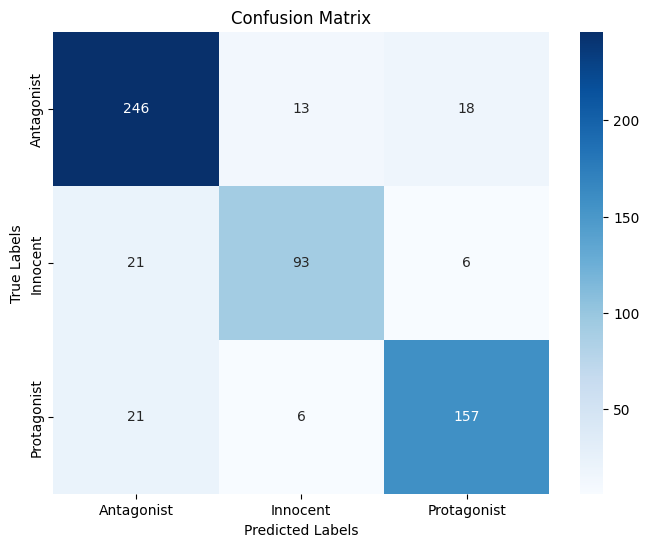

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Antagonist', 'Innocent', 'Protagonist'], yticklabels=['Antagonist', 'Innocent', 'Protagonist'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Comments for the future work
- around 20% of predictions for the class 'innocent' is false predicted - this is very expected in the sentiment classification and polarity problems, that a neutral label will be harder to predict
- around 16.9% of predictions for the class 'protagonist' is false predicted
- around 15.7% of predictions for the class 'antagonist' is false predicted (note that 'antagonist' has significantly more representations in our dataset than 'innocent' and 'protagonist,' which could easily introduce bias into our model)

- many false predictions are coming from the "opposite" classes, which could be easily influenced by models' bad generalization and tendency to memorize articles that are having the same 2 topics, for example in the non-Russian articles, Russia could be a Antagonist, and Russian articles are probably naming themself a innocent or protagonist (should be explored directly when evaluating the model)